## Homework 4: Self Attention

Author: Cao Yanfei

### Task description
- Classify the speakrs of given features.
- Main goal: Learn how to use transformer.
- Baselines:
    - Easy: Run sample code and know how to use transformer.
    - Medium: Know how to adjust parameters of transformer.
    - Hard: Construct [conformer](https://arxiv.org/abs/2005.08100) which is a variety of transformer.

- Other links
  - Kaggle: [link](https://www.kaggle.com/t/859c9ca9ede14fdea841be627c412322)
  - Slide: [link](https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW04/HW04.pdf)
  - Data: [link](https://drive.google.com/file/d/1T0RPnu-Sg5eIPwQPfYysipfcz81MnsYe/view?usp=sharing)
  - Video (Chinese): [link](https://www.youtube.com/watch?v=EPerg2UnGaI)
  - Video (English): [link](https://www.youtube.com/watch?v=Gpz6AUvCak0)
  - Solution for downloading dataset fail.: [link](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e?usp=sharing)

### Download dataset

- Please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e?usp=sharing) to download the data
- Data is [here](https://drive.google.com/file/d/1gaFy8RaQVUEXo2n0peCBR5gYKCB-mNHc/view?usp=sharing)

In [1]:
# !gdown --id 'paste your own data download link' --output Dataset.zip
# !upzip Dataset.zip

### Dataset

- Original dataset is [Voxceleb1](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/).
- The [license](https://creativecommons.org/licenses/by/4.0/) and [complete version](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/files/license.txt) of Voxceleb1.
- We randomly select 600 speakers from Voxceleb1.
- Then preprocess the raw waveforms into mel-spectrograms.

- Args:
    - data_dir: The path to the data directory.
    - metadata_path: The path to the metadata.
    - segment_len: The length of audio segment for training.
- The architecture of data directory \
    - data directory \
    |---- metadata.json \
    |---- testdata.json \
    |---- mapping.json \
    |---- uttr-{random string}.pt \

- The information in metadata
    - `n_mels`: The dimension of mel-spectrogram.
    - `speakers`: A dictionary.
        - key: speaker ids.
        - value: 'feature_path' and 'mel_len'

For efficiency, we segment the mel-spectrograms into segments in the training step.

In [2]:
import os
import json
import torch
import random
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

In [3]:
class MyDataset(Dataset):
    '''
    member:
    self.data_dir
    self.segment_len
    self.speaker2id
    self.speaker_num
    self.data
    '''
    def __init__(self, data_dir, segment_len=128):
        self.data_dir = data_dir
        self.segment_len = segment_len
        
        # Load the mapping from speaker name to their corresponding id.
        mapping_path = Path(data_dir) / 'mapping.json'
        mapping = json.load(mapping_path.open())                # Path_object.open() is like open(Path_object)
        self.speaker2id = mapping['speaker2id']
        
        # Load metadata of training data.
        metadata_path = Path(data_dir) / 'metadata.json'         # Path() returns a path object
        metadata = json.load(open(metadata_path))['speakers']    # open() opens a file and returns a file object, and it will raise OSError when failure occurs.
        
        # Get the total number of speaker.
        self.speaker_num = len(metadata.keys())
        self.data = []
        for speaker in metadata.keys():
            for utterances in metadata[speaker]:
                self.data.append([utterances['feature_path'], self.speaker2id[speaker]])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        feature_path, speaker = self.data[index]
        # Load preprocessed mel-spectrogram.
        mel = torch.load(os.path.join(self.data_dir, feature_path))    # os.path.join() connect two or more path name, add '/' automatically.
        
        # Segment mel-spectrogram into 'segment_len' frames.
        if len(mel) > self.segment_len:
            # Randomly get the starting point of the segment.
            start = random.randint(0, len(mel) - self.segment_len) # random.randint(a, b) returns a random int between [a, b]
            # Get a asegment with 'segment_len' frames.
            mel = torch.FloatTensor(mel[start: start + self.segment_len])
        else:
            mel = torch.FloatTensor(mel)
        # Turn the speaker id into long for computing loss later.
        speaker = torch.FloatTensor([speaker]).long()
        return mel, speaker
    
    def get_speaker_number(self):
        return self.speaker_num

### Dataloader

- Split dataset into training dataset (90%) and validation dataset (10%).
- Create dataloader to iterate the data.

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

In [5]:
def collate_batch(batch):
    '''
    Process features within a batch.
    Collate a batch of data.
    '''
    mel, speaker = zip(*batch)
    # Because we train the model batch by batch, we need to pad the features in the same batch to make their lengths the same.
    mel = pad_sequence(mel, batch_first=True, padding_value=-20)    # pad log 10^(-20) which is a very small value.
    # mel: (batch size, length, 40)
    return mel, torch.FloatTensor(speaker).long()

def get_dataloader(data_dir, batch_size, n_workers):
    '''
    Generate dataloader
    '''
    dataset = MyDataset(data_dir)
    speaker_num = dataset.get_speaker_number()
    # Split dataset into training dataset and validation dataset
    trainlen = int(0.9 * len(dataset))
    lengths = [trainlen, len(dataset) - trainlen]
    trainset, validset = random_split(dataset, lengths)
    
    train_loader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=n_workers,
        pin_memory=True,
        collate_fn=collate_batch,
    )
    valid_loader = DataLoader(
        validset,
        batch_size=batch_size,
        num_workers=n_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=collate_batch,
    )
    
    return train_loader, valid_loader, speaker_num

### Model

- TransformerEncoderLayer:
    - `Base transformer encoder layer` in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
    - Parameters:
        - `d_model`: the number of expected features of the input (required).
        - `nhead`: the number of heads of the multiheadattention models (required).
        - `dim_feedforward`: the dimension of the feedforward network model (default=2048).
        - `dropout`: the dropout value (default=0.1).
        - `activation`: the activation function of intermediate layer, relu or gelu (default=relu).
    - TransformerEncoder:
        - TransformerEncoder is a stack of N transformer encoder layers
        - Parameters:
            - `encoder_layer`: an instance of the TransformerEncoderLayer() class (required).
            - `num-layers`: the number of sub-encoder-layers in the encoder (required).
            - `norm`: the layer normalizarion component (optional).

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# TODO........................................
# import module 'conformer'
from conformer import ConformerBlock

class Classifier(nn.Module):
    '''
    members:
        self.prenet
        self.encoder_layer
    '''
    def __init__(self, d_model=80, n_speakers=600, dropout=0.1):
        super().__init__()
        # Project the dimension of features from that of input into d_model.
        self.prenet = nn.Linear(40, d_model)
        
        # Transformer layer
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, dim_feedforward=256, nhead=1
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)    # num_layers: layer nums of encoder layers
        
        # TODO..............................................................
        # Change Transformer to Conformer (A variety of Transformer).
        # https://arxiv.org/abs/2005.08100
        self.conformer_layer = ConformerBlock(
            dim=d_model, 
            dim_head=64, 
            heads=1,                    # Though we can set multiheads, one head is enough for the model in this task.
            ff_mult=4,                  # ff_mult is used as a multiplier of Linear layer in Feed Forward Network.
            conv_expansion_factor=4,    # conv_expansion_factor is used as a multiplier in convolution.
            conv_kernel_size=31, 
            attn_dropout=dropout, 
            ff_dropout=dropout, 
            conv_dropout=dropout
        )
        
        # Project the dimension of features from d_model into speaker nums.
        self.pred_layer = nn.Sequential(
            # nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, n_speakers),
        )
    
    def forward(self, mels):
        '''
        args:
            mels: (batch size, length, 40)
        return:
            out: (batch size, n_speakers)
        '''
        # out: (batch size, length, d_model)
        out = self.prenet(mels)
        # out: (length, batch size, d_model)
        out = out.permute(1, 0, 2)             # permute(): permute dimensions of a tensor
        # The encoder layer expect features in the shape of (length, batch size, d_model).
        # out = self.encoder(out)
        out = self.conformer_layer(out)
        
        # out: (batch size, length, d_model)
        out = out.transpose(0, 1)              # transpose(): transpose dimensions of a tensor
        # mean pooling
        stats = out.mean(dim=1)
        
        # out: (batch size, n_speakers)
        out = self.pred_layer(stats)
        return out

### Learning rate schedule

- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the `warmup of learning rate is useful` for training models with transformer architectures.
- The `warmup schedule`
    - Set learning rate to 0 in the beginning
    - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [7]:
import math
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR

def get_cosine_schedule_with_warmup(
    optimizer: Optimizer, 
    num_warmup_steps: int, 
    num_training_steps: int,
    num_cycles: float=0.5,
    last_epoch: int=-1,
):
    '''
    Create a schedule with a learning rate that decreases following the values of the cosine function 
    between the initial lr set in the optimizer to 0, after a warmup period during which it increases 
    linearly between 0 and the initial lr set in the optimizer.
    
    Args:
        optimizer (:class:`~torch.optim.Optimzer`): The optimzer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`): The number of steps for the warmup phase.
        num_training_steps (:obj:`int`): The total number of training steps.
        num_cycles (:obj:`float`, `optional`, defaults to 0.5): The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0 following a half-cosine).
        last_epoch (:obj:`int`, `optional`, defaults to -1): The index of the last epoch when resuming training.
        
    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    '''
    def lr_lambda(current_step):
        # Warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
    
    return LambdaLR(optimizer, lr_lambda, last_epoch)

### Model function

- Model forward function.

In [8]:
def model_fn(batch_data, model, criterion, device):
    '''
    Forward a batch through the model.
    '''
    
    mels, labels = batch_data
    mels = mels.to(device)
    labels = labels.to(device)
    
    outs = model(mels)
    
    loss = criterion(outs, labels)
    
    # Get the speaker id with highest probability.
    preds = outs.argmax(1)
    # Compute accuracy.
    accuracy = torch.mean((preds == labels).float())
    
    return loss, accuracy

### Validate

- Calculate accuracy of the validation set.

In [9]:
from tqdm import tqdm

def valid(dataloader, model, criterion, device):
    '''
    Validate on validation set.
    '''
    
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc='Valid', unit='uttr')
    
    for i, batch_data in enumerate(dataloader):
        with torch.no_grad():
            loss, accuracy = model_fn(batch_data, model, criterion, device)
            running_loss += loss.item()
            running_accuracy += accuracy.item()
            
        pbar.update(dataloader.batch_size)
        pbar.set_postfix(
            loss=f'{running_loss / (i + 1):.2f}',
            accuracy=f'{running_accuracy / (i + 1):.2f}',
        )
        
    pbar.close()
    model.train()
    
    return running_loss / len(dataloader), running_accuracy / len(dataloader)

### Training and validation visualization


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_loss_curve(loss_record, batch_num, title=''):
    '''
    Plot learning loss curve (training and validation loss).
    '''
    total_steps = len(loss_record['train'])
    # each batch
    x1 = np.arange(total_steps)
    x2 = x1[:: len(loss_record['train']) // len(loss_record['validate'])]
   
    figure(figsize=(10, 8))
    # T10调色盘适用于离散分类，颜色名称以'tab:'为前缀
    plt.plot(x1, loss_record['train'], c='tab:red', label='training')
    plt.plot(x2, loss_record['validate'], c='tab:cyan', label='validation')
    plt.xlim(-2, batch_num * 1.01)
    plt.ylim(0., 10.)
    plt.xticks(np.arange(0, batch_num * 1.01, batch_num // 10))
    plt.yticks(np.arange(0., 10., 1))
    plt.xlabel('Training step/Batch')
    plt.ylabel('CrossEntropy loss')
    plt.title('Learning loss curve of {}'.format(title))
    plt.legend()
    plt.show()
    
def plot_acc_curve(acc_record, batch_num, title=''):
    '''
    Plot learning accuracy curve (training and validation accuracy).
    '''
    total_steps = len(acc_record['train'])
    # each batch
    x1 = np.arange(total_steps)
    x2 = x1[:: len(acc_record['train']) // len(acc_record['validate'])]
   
    figure(figsize=(10, 8))
    # T10调色盘适用于离散分类，颜色名称以'tab:'为前缀
    plt.plot(x1, acc_record['train'], c='tab:red', label='training')
    plt.plot(x2, acc_record['validate'], c='tab:cyan', label='validation')
    plt.xlim(-2, batch_num * 1.01)
    plt.ylim(0., 1.2)
    plt.xticks(np.arange(0, batch_num * 1.01, batch_num // 10))
    plt.yticks(np.arange(0., 1.2, 0.2))
    plt.xlabel('Training step/Batch')
    plt.ylabel('Accuracy')
    plt.title('Learning accuracy curve of {}'.format(title))
    plt.legend()
    plt.show() 

### Main function

[Info]: Use cpu now!
[Info]: Finish loading data!
[Info]: Finish creating model!


Train: 100% 2000/2000 [11:37<00:00,  2.87step/s, accuracy=0.16, loss=4.61, step=2000]
Valid: 100% 6944/6944 [00:28<00:00, 245.27uttr/s, accuracy=0.15, loss=4.34]
Train: 100% 2000/2000 [11:20<00:00,  2.94step/s, accuracy=0.25, loss=3.57, step=4000]
Valid: 100% 6944/6944 [00:28<00:00, 241.15uttr/s, accuracy=0.30, loss=3.35]
Train: 100% 2000/2000 [11:27<00:00,  2.91step/s, accuracy=0.34, loss=3.09, step=6000]
Valid: 100% 6944/6944 [00:28<00:00, 246.56uttr/s, accuracy=0.37, loss=2.91]
Train: 100% 2000/2000 [11:20<00:00,  2.94step/s, accuracy=0.28, loss=2.83, step=8000]
Valid: 100% 6944/6944 [00:29<00:00, 237.85uttr/s, accuracy=0.42, loss=2.66]
Train: 100% 2000/2000 [11:23<00:00,  2.92step/s, accuracy=0.56, loss=2.25, step=1e+4]
Valid: 100% 6944/6944 [00:28<00:00, 241.67uttr/s, accuracy=0.47, loss=2.41]
Train:   0% 0/2000 [00:00<?, ?step/s]

Step: 10000, best model saved. (accuracy=0.4703)


Train: 100% 2000/2000 [11:23<00:00,  2.93step/s, accuracy=0.50, loss=2.38, step=12000]
Valid: 100% 6944/6944 [00:32<00:00, 213.82uttr/s, accuracy=0.51, loss=2.23]
Train: 100% 2000/2000 [11:22<00:00,  2.93step/s, accuracy=0.69, loss=1.69, step=14000]
Valid: 100% 6944/6944 [00:28<00:00, 241.34uttr/s, accuracy=0.52, loss=2.15]
Train: 100% 2000/2000 [11:24<00:00,  2.92step/s, accuracy=0.66, loss=1.92, step=16000]
Valid: 100% 6944/6944 [00:28<00:00, 242.65uttr/s, accuracy=0.55, loss=2.01]
Train: 100% 2000/2000 [11:25<00:00,  2.92step/s, accuracy=0.72, loss=1.39, step=18000]
Valid: 100% 6944/6944 [00:28<00:00, 241.54uttr/s, accuracy=0.57, loss=1.90]
Train: 100% 2000/2000 [11:26<00:00,  2.91step/s, accuracy=0.62, loss=1.69, step=2e+4] 
Valid: 100% 6944/6944 [00:29<00:00, 233.70uttr/s, accuracy=0.59, loss=1.81]
Train:   0% 0/2000 [00:00<?, ?step/s]

Step: 20000, best model saved. (accuracy=0.5899)


Train: 100% 2000/2000 [11:19<00:00,  2.94step/s, accuracy=0.59, loss=1.83, step=22000]
Valid: 100% 6944/6944 [00:28<00:00, 241.15uttr/s, accuracy=0.61, loss=1.70]
Train: 100% 2000/2000 [11:21<00:00,  2.94step/s, accuracy=0.72, loss=1.07, step=24000]
Valid: 100% 6944/6944 [00:28<00:00, 243.51uttr/s, accuracy=0.63, loss=1.61]
Train: 100% 2000/2000 [11:22<00:00,  2.93step/s, accuracy=0.78, loss=1.21, step=26000]
Valid: 100% 6944/6944 [00:28<00:00, 244.71uttr/s, accuracy=0.63, loss=1.57]
Train: 100% 2000/2000 [11:19<00:00,  2.95step/s, accuracy=0.75, loss=0.87, step=28000]
Valid: 100% 6944/6944 [00:28<00:00, 242.33uttr/s, accuracy=0.65, loss=1.51]
Train: 100% 2000/2000 [11:20<00:00,  2.94step/s, accuracy=0.75, loss=1.28, step=3e+4] 
Valid: 100% 6944/6944 [00:28<00:00, 240.06uttr/s, accuracy=0.66, loss=1.51]
Train:   0% 0/2000 [00:00<?, ?step/s]

Step: 30000, best model saved. (accuracy=0.6555)


Train: 100% 2000/2000 [11:20<00:00,  2.94step/s, accuracy=0.66, loss=1.50, step=32000]
Valid: 100% 6944/6944 [00:28<00:00, 241.13uttr/s, accuracy=0.66, loss=1.44]
Train: 100% 2000/2000 [11:22<00:00,  2.93step/s, accuracy=0.75, loss=1.11, step=34000]
Valid: 100% 6944/6944 [00:28<00:00, 243.57uttr/s, accuracy=0.67, loss=1.39]
Train: 100% 2000/2000 [11:22<00:00,  2.93step/s, accuracy=0.59, loss=1.67, step=36000]
Valid: 100% 6944/6944 [00:29<00:00, 235.65uttr/s, accuracy=0.68, loss=1.38]
Train: 100% 2000/2000 [11:22<00:00,  2.93step/s, accuracy=0.75, loss=0.93, step=38000]
Valid: 100% 6944/6944 [00:28<00:00, 245.13uttr/s, accuracy=0.70, loss=1.31]
Train: 100% 2000/2000 [11:21<00:00,  2.93step/s, accuracy=0.78, loss=0.91, step=4e+4] 
Valid: 100% 6944/6944 [00:28<00:00, 245.38uttr/s, accuracy=0.71, loss=1.27]
Train:   0% 0/2000 [00:00<?, ?step/s]

Step: 40000, best model saved. (accuracy=0.7061)


Train: 100% 2000/2000 [11:22<00:00,  2.93step/s, accuracy=0.69, loss=1.01, step=42000]
Valid: 100% 6944/6944 [00:28<00:00, 243.83uttr/s, accuracy=0.71, loss=1.26]
Train: 100% 2000/2000 [11:25<00:00,  2.92step/s, accuracy=0.78, loss=1.15, step=44000]
Valid: 100% 6944/6944 [00:28<00:00, 241.59uttr/s, accuracy=0.72, loss=1.22]
Train: 100% 2000/2000 [11:22<00:00,  2.93step/s, accuracy=0.53, loss=1.94, step=46000]
Valid: 100% 6944/6944 [00:28<00:00, 240.06uttr/s, accuracy=0.72, loss=1.19]
Train: 100% 2000/2000 [11:20<00:00,  2.94step/s, accuracy=0.75, loss=1.00, step=48000]
Valid: 100% 6944/6944 [00:28<00:00, 242.33uttr/s, accuracy=0.73, loss=1.18]
Train: 100% 2000/2000 [11:18<00:00,  2.95step/s, accuracy=0.72, loss=1.15, step=5e+4] 
Valid: 100% 6944/6944 [00:28<00:00, 247.09uttr/s, accuracy=0.72, loss=1.18]
Train:   0% 0/2000 [00:00<?, ?step/s]

Step: 50000, best model saved. (accuracy=0.7260)


Train: 100% 2000/2000 [11:22<00:00,  2.93step/s, accuracy=0.81, loss=0.86, step=52000]
Valid: 100% 6944/6944 [00:31<00:00, 220.93uttr/s, accuracy=0.74, loss=1.13]
Train: 100% 2000/2000 [11:48<00:00,  2.82step/s, accuracy=0.81, loss=1.01, step=54000]
Valid: 100% 6944/6944 [00:28<00:00, 245.10uttr/s, accuracy=0.74, loss=1.12]
Train: 100% 2000/2000 [11:24<00:00,  2.92step/s, accuracy=0.78, loss=0.65, step=56000]
Valid: 100% 6944/6944 [00:28<00:00, 242.22uttr/s, accuracy=0.75, loss=1.11]
Train: 100% 2000/2000 [11:23<00:00,  2.93step/s, accuracy=0.84, loss=0.85, step=58000]
Valid: 100% 6944/6944 [00:28<00:00, 239.65uttr/s, accuracy=0.75, loss=1.09]
Train: 100% 2000/2000 [11:26<00:00,  2.91step/s, accuracy=0.75, loss=0.90, step=6e+4] 
Valid: 100% 6944/6944 [00:28<00:00, 242.05uttr/s, accuracy=0.75, loss=1.06]
Train:   0% 0/2000 [00:00<?, ?step/s]

Step: 60000, best model saved. (accuracy=0.7526)


Train: 100% 2000/2000 [11:23<00:00,  2.93step/s, accuracy=0.75, loss=0.77, step=62000]
Valid: 100% 6944/6944 [00:29<00:00, 238.20uttr/s, accuracy=0.75, loss=1.11]
Train: 100% 2000/2000 [11:28<00:00,  2.90step/s, accuracy=0.75, loss=0.97, step=64000]
Valid: 100% 6944/6944 [00:28<00:00, 245.05uttr/s, accuracy=0.75, loss=1.07]
Train: 100% 2000/2000 [11:23<00:00,  2.92step/s, accuracy=0.75, loss=0.86, step=66000]
Valid: 100% 6944/6944 [00:28<00:00, 245.89uttr/s, accuracy=0.74, loss=1.10]
Train: 100% 2000/2000 [11:23<00:00,  2.93step/s, accuracy=0.84, loss=0.76, step=68000]
Valid: 100% 6944/6944 [00:29<00:00, 238.15uttr/s, accuracy=0.75, loss=1.08]
Train: 100% 2000/2000 [11:22<00:00,  2.93step/s, accuracy=0.81, loss=0.73, step=7e+4] 
Valid: 100% 6944/6944 [00:29<00:00, 239.07uttr/s, accuracy=0.75, loss=1.09]
Train:   0% 0/2000 [00:00<?, ?step/s]


Step: 70000, best model saved. (accuracy=0.7526)


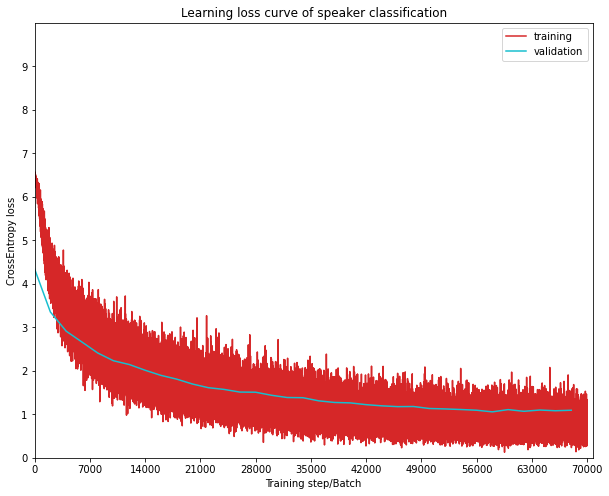

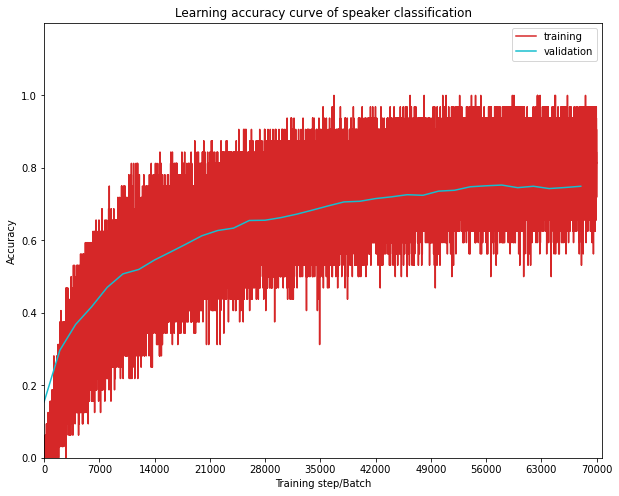

In [11]:
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split

def parse_args():
    '''
    arguments
    '''
    config = {
        'data_dir': './Dataset',
        'save_path':'model.ckpt',
        'batch_size': 32,
        'n_workers': 0,
        'valid_steps': 2000, 
        'warmup_steps':1000, 
        'save_steps': 10000, 
        'total_steps': 70000,
    }
    
    return config

def main(
    data_dir, 
    save_path, 
    batch_size, 
    n_workers, 
    valid_steps, 
    warmup_steps, 
    total_steps, 
    save_steps, 
): 
    '''
    Main function
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'[Info]: Use {device} now!')
    
    train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
    train_iterator = iter(train_loader)
    print(f'[Info]: Finish loading data!', flush=True)
    
    model = Classifier(n_speakers=speaker_num).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=1e-3)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    print(f'[Info]: Finish creating model!', flush=True)
    
    best_accuracy = -1.0
    best_state_dic = None
    
    pbar = tqdm(total=valid_steps, ncols=0, desc='Train', unit='step')
    
    loss_record = {'train': [], 'validate': []}
    acc_record = {'train': [], 'validate': []}
    
    for step in range(total_steps):
        # Get data
        try:
            batch_data = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            batch_data = next(train_iterator)
            
        loss, accuracy = model_fn(batch_data, model, criterion, device)
        batch_loss = loss.item()
        batch_accuracy = accuracy.item()
        
        loss_record['train'].append(batch_loss)
        acc_record['train'].append(batch_accuracy)
        
        # Update model
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        # Log
        pbar.update()
        pbar.set_postfix(
            loss=f'{batch_loss:.2f}',
            accuracy=f'{batch_accuracy:.2f}',
            step=step + 1,
        )
        
        # Do validation
        if (step + 1) % valid_steps == 0:
            pbar.close()
            
            valid_loss, valid_accuracy = valid(valid_loader, model, criterion, device)
            
            loss_record['validate'].append(valid_loss)
            acc_record['validate'].append(valid_accuracy)
            
            # keep the best model
            if valid_accuracy > best_accuracy: 
                best_accuracy = valid_accuracy
                best_state_dict = model.state_dict()
            
            pbar = tqdm(total=valid_steps, ncols=0, desc='Train', unit='step')
        
        # Save the best model so far.
        if (step + 1) % save_steps == 0 and best_state_dict is not None:
            torch.save(best_state_dict, save_path)
            pbar.write(f'Step: {step + 1}, best model saved. (accuracy={best_accuracy:.4f})')
            
    pbar.close()
    
    # loss and accuracy visulization
    plot_loss_curve(loss_record, total_steps, 'speaker classification')
    
    plot_acc_curve(acc_record, total_steps, 'speaker classification')
    
if __name__ == '__main__':
    main(**parse_args())

### Inference

### Dataset of inference

In [12]:
class InferenceDataset(Dataset):
    '''
    members:
        self.data_dir
        self.data
    '''
    def __init__(self, data_dir):
        testdata_path = Path(data_dir) / 'testdata.json'
        metadata = json.load(testdata_path.open())
        self.data_dir = data_dir
        self.data = metadata['utterances']
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        utterance = self.data[index]
        feature_path = utterance['feature_path']
        mel = torch.load(os.path.join(self.data_dir, feature_path))
        
        return feature_path, mel
    
def inference_collate_batch(batch_data):
    '''
    Collate a batch of data.
    '''
    feature_paths, mels = zip(*batch_data)
    
    return feature_paths, torch.stack(mels)      # torch.stack(): torch a iterable object with tensor element into a tensor object

### Main function of interface

In [13]:
import csv
from tqdm.notebook import tqdm

def parse_args_inference():
    '''
    Arguments
    '''
    config = {
        'data_dir': './Dataset',
        'model_path': './model.ckpt', 
        'output_path': './output.csv',
    }
    
    return config

def main_inference(
    data_dir, 
    model_path, 
    output_path, 
):
    '''
    Main function for inference.
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'[Info]: Use {device} now!')
    
    mapping_path = Path(data_dir) / 'mapping.json'
    mapping = json.load(mapping_path.open())
    
    dataset = InferenceDataset(data_dir)
    dataloader = DataLoader(
        dataset, 
        batch_size=1, 
        shuffle=False, 
        num_workers=0, 
        collate_fn=inference_collate_batch, 
    )
    print(f'[Info]: Finish loading inference data!', flush=True)
    
    speaker_num = len(mapping['id2speaker'])
    model = Classifier(n_speakers=speaker_num).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f'[Info]: Finish creating and loading model!', flush=True)
    
    results = [['Id', 'Category']]
    for feature_paths, mels in tqdm(dataloader): 
        with torch.no_grad():
            mels = mels.to(device)
            outs = model(mels)
            preds = outs.argmax(1).cpu().numpy()
            
            for feature_path, pred in zip(feature_paths, preds): 
                results.append([feature_path, mapping['id2speaker'][str(pred)]])
    
    with open(output_path, 'w', newline='') as csvfile: 
        writer = csv.writer(csvfile)
        writer.writerows(results)
        
if __name__ == '__main__': 
    main_inference(**parse_args_inference())

[Info]: Use cpu now!
[Info]: Finish loading inference data!
[Info]: Finish creating and loading model!


  0%|          | 0/6000 [00:00<?, ?it/s]

### Reference

Original source: https://github.com/ga642381/ML2021-Spring/blob/main/HW04/HW04.ipynb